

# Bài tập lớn môn Nhập môn Học máy và Khai phá dữ liệu
## Dự đoán khả năng mắc bệnh tiểu đường

Tập dữ liệu: [Diabetes Prediction Dataset](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset/data)

Mục tiêu: Xây dựng mô hình học máy để dự đoán khả năng mắc bệnh tiểu đường dựa trên các đặc trưng như tuổi, giới tính, chỉ số BMI, mức đường huyết, v.v.

Các bước thực hiện:
1. Thu thập và đọc dữ liệu
2. Trực quan hóa dữ liệu
3. Tiền xử lý dữ liệu
4. Huấn luyện mô hình
5. Đánh giá mô hình

***Khai báo các thư viện sử dụng***

In [ ]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
scaler.fit(X_train_IQR)
X_train_scaled_IQR = scaler.transform(X_train_IQR)
X_test_scaled_IQR = scaler.transform(X_test_IQR)

# Chuyển về DataFrame để dễ kiểm tra
X_train_scaled_IQR = pd.DataFrame(X_train_scaled_IQR, columns=X_train_IQR.columns)
X_test_scaled_IQR = pd.DataFrame(X_test_scaled_IQR, columns=X_test_IQR.columns)

# Kiểm tra thống kê sau chuẩn hóa
print("Thống kê tập huấn luyện sau chuẩn hóa:")
print(X_train_scaled_IQR.describe())

Thống kê tập huấn luyện sau chuẩn hóa:
             gender           age  hypertension  heart_disease  \
count  7.691600e+04  7.691600e+04  7.691600e+04   7.691600e+04   
mean   8.207879e-17  2.398160e-16  1.071597e-17   9.713658e-17   
std    1.000007e+00  1.000007e+00  1.000007e+00   1.000007e+00   
min   -8.459839e-01 -1.855158e+00 -2.908731e-01  -2.064408e-01   
25%   -8.459839e-01 -7.905148e-01 -2.908731e-01  -2.064408e-01   
50%   -8.459839e-01  5.514685e-02 -2.908731e-01  -2.064408e-01   
75%    1.180289e+00  7.672829e-01 -2.908731e-01  -2.064408e-01   
max    3.206562e+00  1.701962e+00  3.437926e+00   4.844004e+00   

       smoking_history           bmi   HbA1c_level  blood_glucose_level  
count     7.691600e+04  7.691600e+04  7.691600e+04         7.691600e+04  
mean     -5.062372e-17 -1.414323e-16  4.560292e-16         3.153821e-16  
std       1.000007e+00  1.000007e+00  1.000007e+00         1.000007e+00  
min      -1.187166e+00 -2.248246e+00 -1.893417e+00        -1.485392e+0

In [26]:
# Nhập các thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
import xgboost as xgb
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.combine import SMOTEENN
import time
import os

# Thiết lập style cho biểu đồ
sns.set(style="whitegrid")
%matplotlib inline

## 1. Thu thập và đọc dữ liệu

**Thu thập dữ liệu**


In [27]:
# Đọc dữ liệu
data = pd.read_csv('data/diabetes_prediction_dataset.csv')

# Hiển thị thông tin cơ bản
print("Thông tin dữ liệu:")
print(data.info())
print("\nMẫu dữ liệu đầu tiên:")
print(data.head())

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None

Mẫu dữ liệu đầu tiên:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Mal

**Giải thích các thuộc tính trong dữ liệu**
- **Age**: Tuổi là yếu tố quan trọng trong dự đoán nguy cơ tiểu đường. Khi tuổi tăng, nguy cơ mắc tiểu đường tăng do giảm hoạt động thể chất, thay đổi hormone và khả năng cao mắc các bệnh lý khác góp phần gây tiểu đường.

- **Gender**: Giới tính ảnh hưởng đến nguy cơ tiểu đường, dù tác động khác nhau. Phụ nữ có tiền sử gestational diabetes có nguy cơ cao mắc tiểu đường loại 2 sau này. Một số nghiên cứu cho rằng nam giới có nguy cơ hơi cao hơn nữ giới.

- **Body Mass Index (BMI)**: BMI đo lượng mỡ cơ thể dựa trên chiều cao và cân nặng, là chỉ số đánh giá tình trạng cân nặng và dự đoán nguy cơ tiểu đường. BMI cao làm tăng khả năng mắc tiểu đường loại 2. Mỡ thừa, đặc biệt quanh bụng, gây kháng insulin và làm suy giảm khả năng điều hòa đường huyết.

- **Hypertension**: Tăng huyết áp thường đồng hành với tiểu đường, chia sẻ các yếu tố nguy cơ chung và góp phần vào sự phát triển của nhau. Có hypertension làm tăng nguy cơ tiểu đường loại 2 và ngược lại, cả hai gây hại cho sức khỏe tim mạch.

- **Heart Disease**: Bệnh tim, như bệnh mạch vành hoặc suy tim, liên quan đến tăng nguy cơ tiểu đường. Mối quan hệ này hai chiều, nghĩa là mắc một bệnh làm tăng nguy cơ mắc bệnh kia, do chia sẻ yếu tố nguy cơ như béo phì, tăng huyết áp và cholesterol cao.

- **Smoking History**: Hút thuốc là yếu tố nguy cơ có thể thay đổi. Hút thuốc lá làm tăng nguy cơ tiểu đường loại 2, góp phần gây kháng insulin và suy giảm chuyển hóa glucose. Bỏ thuốc giảm đáng kể nguy cơ tiểu đường và biến chứng.

- **HbA1c Level**: HbA1c đo mức đường huyết trung bình trong 2-3 tháng, phản ánh khả năng kiểm soát đường huyết dài hạn. HbA1c cao cho thấy kiểm soát kém, làm tăng nguy cơ tiểu đường và biến chứng.

- **Blood Glucose Level**: Mức đường huyết là lượng glucose trong máu tại một thời điểm. Đường huyết cao, đặc biệt khi đói hoặc sau khi ăn carbohydrate, cho thấy rối loạn điều hòa glucose và tăng nguy cơ tiểu đường. Theo dõi thường xuyên rất quan trọng để chẩn đoán và quản lý tiểu đường.

---
**Thống kê các thông tin từ dữ liệu**


In [28]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,100000.0,41.885856,22.516840,0.08,24.00,43.00,60.00,80.00
hypertension,100000.0,0.074850,0.263150,0.00,0.00,0.00,0.00,1.00
heart_disease,100000.0,0.039420,0.194593,0.00,0.00,0.00,0.00,1.00
bmi,100000.0,27.320767,6.636783,10.01,23.63,27.32,29.58,95.69
HbA1c_level,100000.0,5.527507,1.070672,3.50,4.80,5.80,6.20,9.00
blood_glucose_level,100000.0,138.058060,40.708136,80.00,100.00,140.00,159.00,300.00
diabetes,100000.0,0.085000,0.278883,0.00,0.00,0.00,0.00,1.00


## 2. Trực quan hóa dữ liệu


### 2.1 Phân phối của các trường dữ liệu

**Biểu đồ phân phối của các trường theo nhãn**

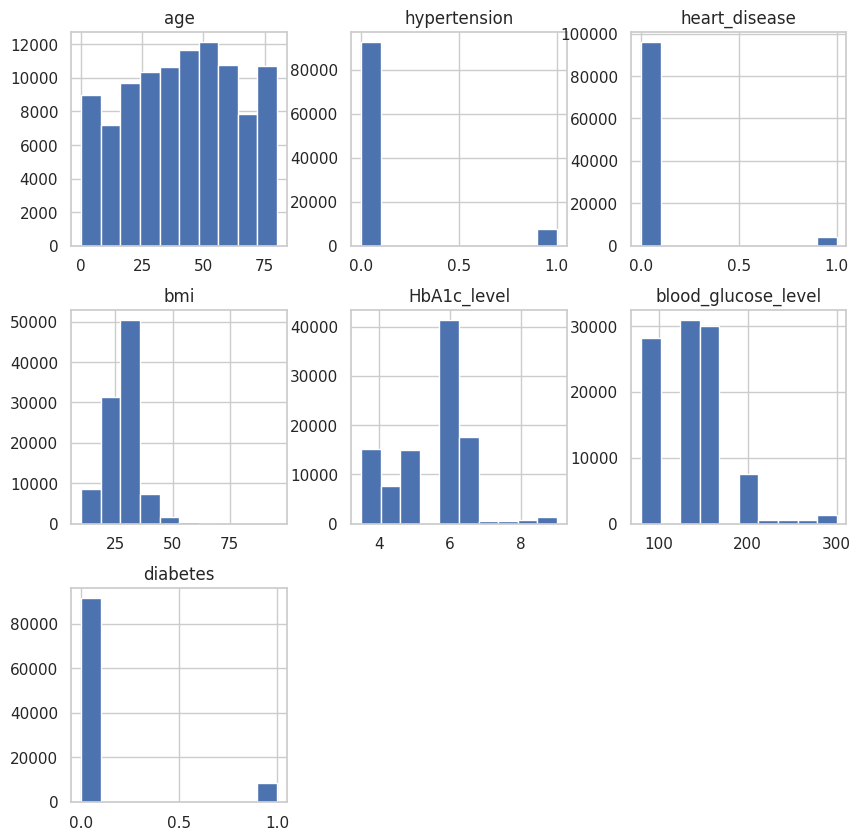

In [29]:
data.hist(figsize = (10,10))
plt.show()

**Kiểm tra phân lớp**

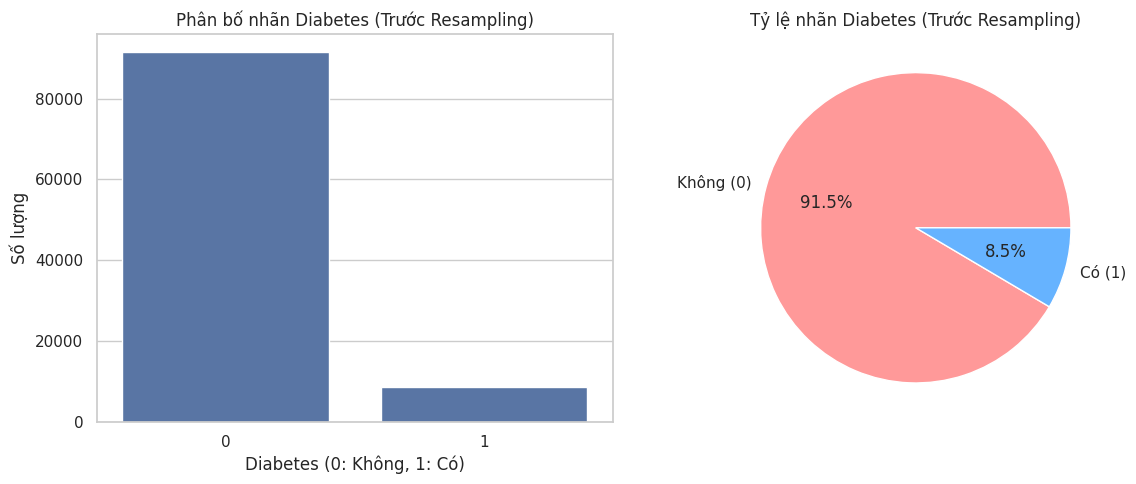

Tỷ lệ lớp trước resampling:
diabetes
0    0.915
1    0.085
Name: count, dtype: float64


In [30]:
# Phân bố nhãn trước resampling
plt.figure(figsize=(12, 5))

# Biểu đồ cột
plt.subplot(1, 2, 1)
sns.countplot(x='diabetes', data=data)
plt.title('Phân bố nhãn Diabetes (Trước Resampling)')
plt.xlabel('Diabetes (0: Không, 1: Có)')
plt.ylabel('Số lượng')

# Biểu đồ tròn
plt.subplot(1, 2, 2)
data['diabetes'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Không (0)', 'Có (1)'], colors=['#ff9999', '#66b3ff'])
plt.title('Tỷ lệ nhãn Diabetes (Trước Resampling)')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Tính tỷ lệ
class_counts = data['diabetes'].value_counts()
print("Tỷ lệ lớp trước resampling:")
print(class_counts / len(data))

Qua biểu đồ trực quan hóa cho thấy, dữ liệu đang bị mất **cân bằng dữ liệu**.

### 2.2 Kiểm tra ngoại lai

**Sử dụng Boxplot để xác định các ngoại lai**

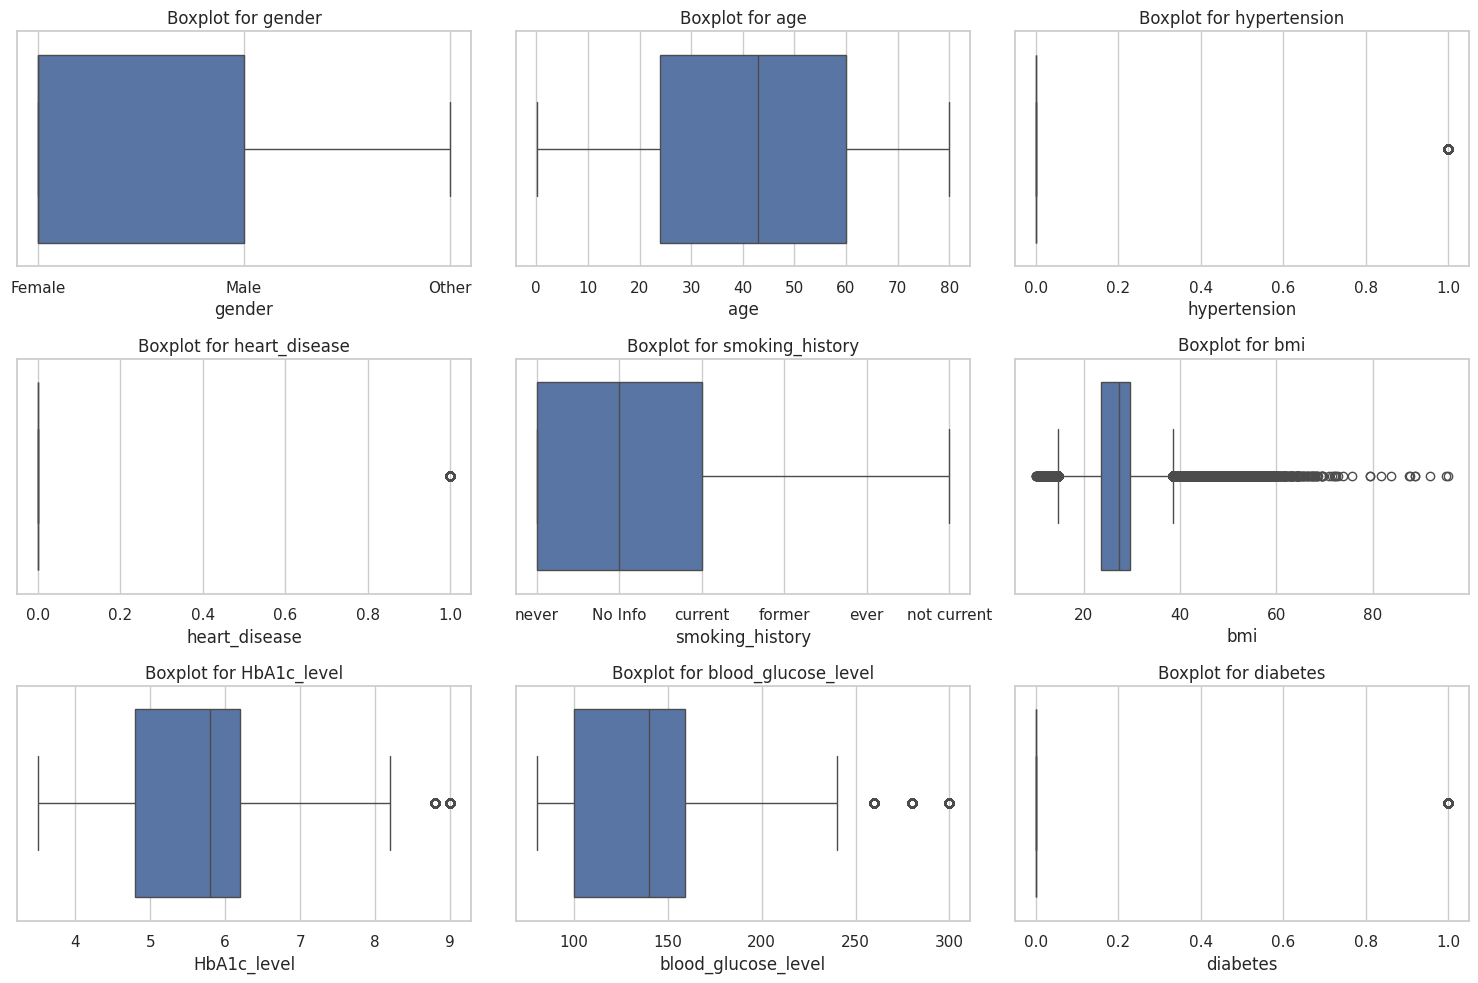

In [31]:
num_rows, num_cols = 3, 3

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Loop through numeric columns and create boxplots
for i, column in enumerate(data.columns):
    sns.boxplot(data=data, x=column, ax=axes[i])
    axes[i].set_title(f'Boxplot for {column}')

# Remove any remaining empty subplots
for j in range(len(data.columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

### 2.3 Pairplot của các đặc trưng số

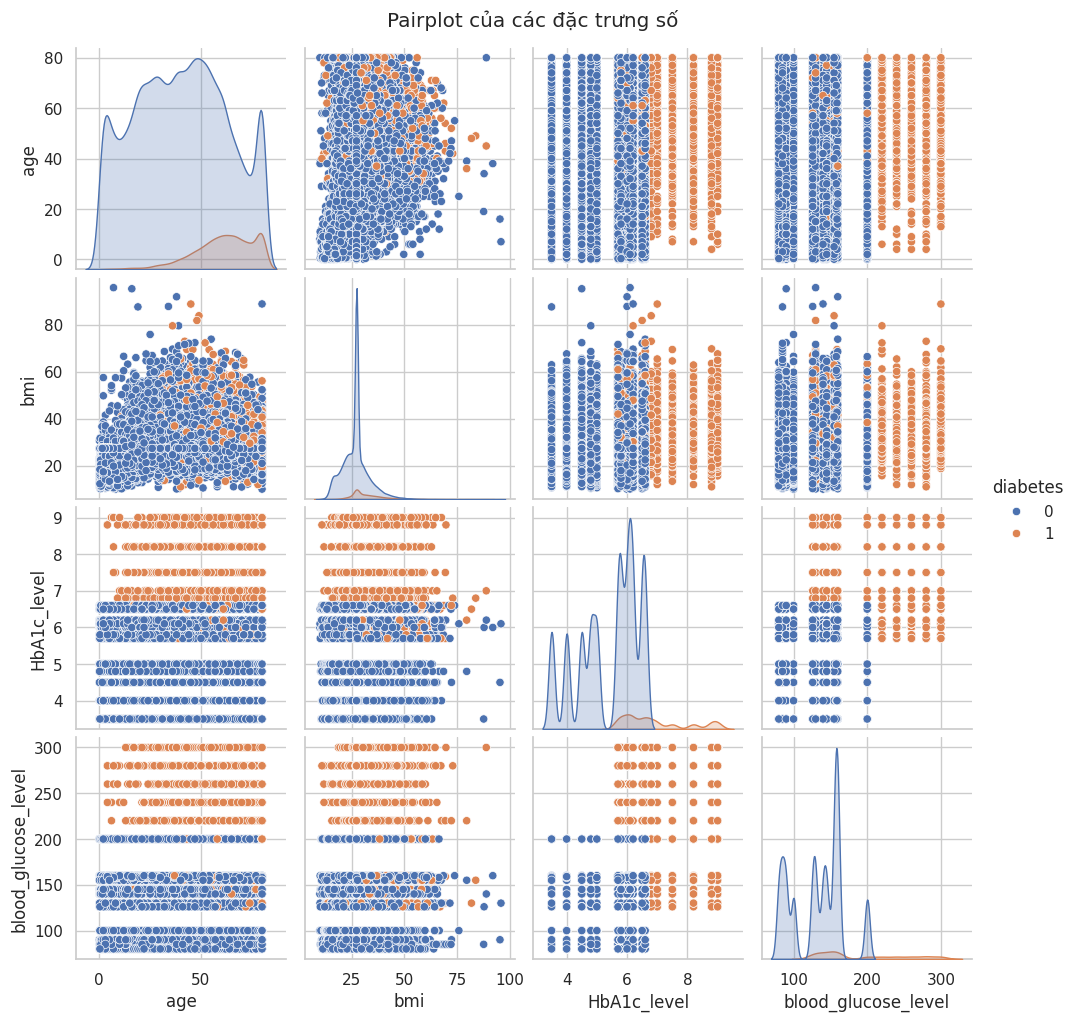

In [32]:
# Pairplot cho các đặc trưng số
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
sns.pairplot(data[numerical_cols + ['diabetes']], hue='diabetes', diag_kind='kde')
plt.suptitle('Pairplot của các đặc trưng số', y=1.02)
plt.show()

### 2.4 Biểu độ tương quan giữa các trường dữ liệu

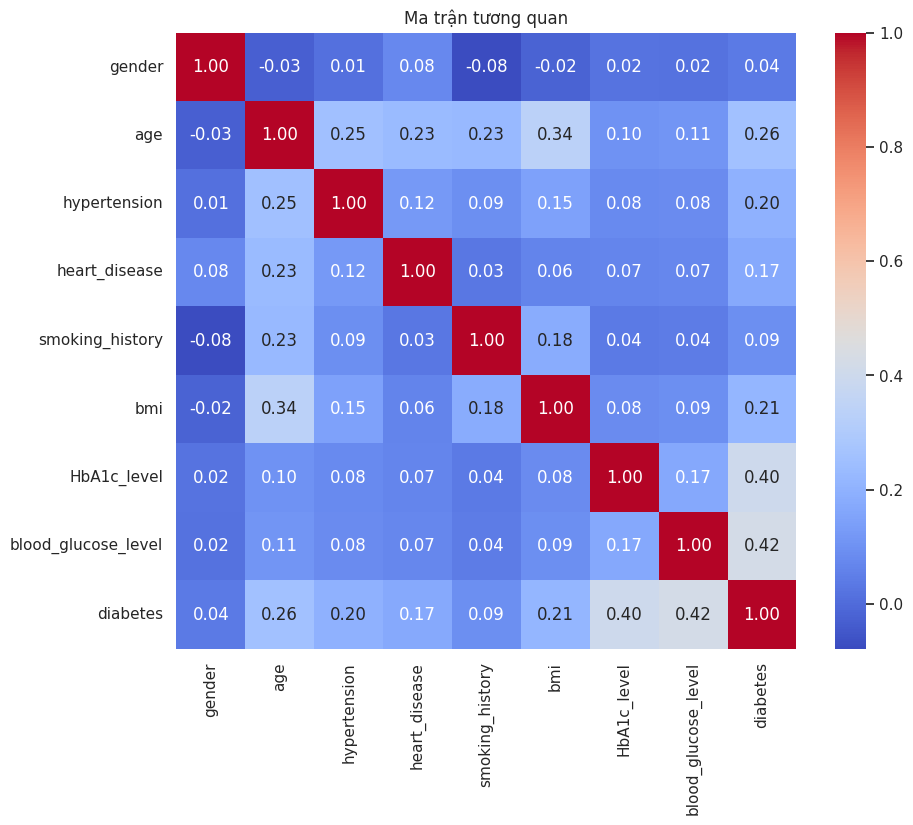

In [33]:
# Mã hóa tạm thời để tính tương quan
data_temp = data.copy()
data_temp['gender'] = LabelEncoder().fit_transform(data_temp['gender'])
data_temp['smoking_history'] = LabelEncoder().fit_transform(data_temp['smoking_history'])

# Ma trận tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(data_temp.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Ma trận tương quan')
plt.savefig('correlation_heatmap.png')
plt.show()

## 3. Tiền xử lý dữ liệu

Dựa trên phân tích EDA, dữ liệu có các vấn đề: mất cân bằng lớp (`diabetes = 1` chiếm chỉ 8.5%), ngoại lệ (`bmi`, `blood_glucose_level`), và giá trị `No Info` trong `smoking_history` (~35%). Các bước tiền xử lý bao gồm:

1. **Xử lý ngoại lệ**: Sử dụng phương pháp IQR để loại bỏ ngoại lệ trong `bmi` và `blood_glucose_level`.
2. **Mã hóa đặc trưng phân loại**: Chuyển `gender` và `smoking_history` thành số bằng `LabelEncoder`.
3. **Chuẩn hóa đặc trưng số**: Đưa các đặc trưng số về cùng thang đo bằng `StandardScaler`.
4. **Cân bằng lớp**: Áp dụng SMOTE để cân bằng lớp `diabetes`.
5. **Chia dữ liệu**: Chia thành tập huấn luyện (80%) và kiểm tra (20%) với `stratify` để giữ tỷ lệ lớp.

Loại bỏ trùng lặp dữ liệu

In [34]:
# check duplicate values
print(data.duplicated().sum())
# remove duplicate values
data = data.drop_duplicates()
print("______Removed Duplicate______")
print(data.duplicated().sum())

3854
______Removed Duplicate______
0


### 3.1. Xử lý ngoại lệ
Sử dụng phương pháp IQR để loại bỏ các giá trị ngoại lệ trong `bmi` và `blood_glucose_level`.

In [35]:
# Hàm capping ngoại lệ
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower_bound, upper_bound)
    return df

# Xử lý ngoại lệ cho bmi và blood_glucose_level
print("Số mẫu trước khi capping ngoại lệ:", len(data))
print("Phân phối lớp trước capping ngoại lệ:\n", data['diabetes'].value_counts(normalize=True))
data_IQR = cap_outliers(data, 'bmi')
data_IQR = cap_outliers(data, 'blood_glucose_level')
print("Số mẫu sau khi capping ngoại lệ:", len(data_IQR))
print("Phân phối lớp sau capping ngoại lệ:\n", data_IQR['diabetes'].value_counts(normalize=True))

Số mẫu trước khi capping ngoại lệ: 96146
Phân phối lớp trước capping ngoại lệ:
 diabetes
0    0.91178
1    0.08822
Name: proportion, dtype: float64
Số mẫu sau khi capping ngoại lệ: 96146
Phân phối lớp sau capping ngoại lệ:
 diabetes
0    0.91178
1    0.08822
Name: proportion, dtype: float64


### 3.2. Mã hóa đặc trưng phân loại
Chuyển `gender` và `smoking_history` thành số. Giữ nguyên No Info trong `smoking_history` như một hạng mục riêng.

In [36]:
# Mã hóa gender và smoking_history
le_gender = LabelEncoder()
le_smoking = LabelEncoder()
data_IQR['gender'] = le_gender.fit_transform(data_IQR['gender'])
data_IQR['smoking_history'] = le_smoking.fit_transform(data_IQR['smoking_history'])

# Kiểm tra dữ liệu sau mã hóa
print("Dữ liệu sau mã hóa:")
print(data_IQR.head())

Dữ liệu sau mã hóa:
   gender   age  hypertension  heart_disease  smoking_history    bmi  \
0       0  80.0             0              1                4  25.19   
1       0  54.0             0              0                0  27.32   
2       1  28.0             0              0                4  27.32   
3       0  36.0             0              0                1  23.45   
4       1  76.0             1              1                1  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                140.0         0  
1          6.6                 80.0         0  
2          5.7                158.0         0  
3          5.0                155.0         0  
4          4.8                155.0         0  


###3.3 Phân chia tập dữ liệu

In [37]:
# Tách đặc trưng và nhãn
X = data_IQR.drop('diabetes', axis=1)
y = data_IQR['diabetes']

# Chia dữ liệu
X_train_IQR, X_test_IQR, y_train_IQR, y_test_IQR = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Kích thước tập huấn luyện:", X_train_IQR.shape)
print("Kích thước tập kiểm tra:", X_test_IQR.shape)
print("Phân phối lớp trong tập huấn luyện:\n", y_train_IQR.value_counts(normalize=True))
print("Phân phối lớp trong tập kiểm tra:\n", y_test_IQR.value_counts(normalize=True))

Kích thước tập huấn luyện: (76916, 8)
Kích thước tập kiểm tra: (19230, 8)
Phân phối lớp trong tập huấn luyện:
 diabetes
0    0.911774
1    0.088226
Name: proportion, dtype: float64
Phân phối lớp trong tập kiểm tra:
 diabetes
0    0.911804
1    0.088196
Name: proportion, dtype: float64


###3.4 Chuẩn hóa các đặc trưng

In [38]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
scaler.fit(X_train_IQR)
X_train_scaled_IQR = scaler.transform(X_train_IQR)
X_test_scaled_IQR = scaler.transform(X_test_IQR)

# Chuyển về DataFrame để dễ kiểm tra
X_train_scaled_IQR = pd.DataFrame(X_train_scaled_IQR, columns=X_train_IQR.columns)
X_test_scaled_IQR = pd.DataFrame(X_test_scaled_IQR, columns=X_test_IQR.columns)

# Kiểm tra thống kê sau chuẩn hóa
print("Thống kê tập huấn luyện sau chuẩn hóa:")
print(X_train_scaled_IQR.describe())

Thống kê tập huấn luyện sau chuẩn hóa:
             gender           age  hypertension  heart_disease  \
count  7.691600e+04  7.691600e+04  7.691600e+04   7.691600e+04   
mean   8.207879e-17  2.398160e-16  1.071597e-17   9.713658e-17   
std    1.000007e+00  1.000007e+00  1.000007e+00   1.000007e+00   
min   -8.459839e-01 -1.855158e+00 -2.908731e-01  -2.064408e-01   
25%   -8.459839e-01 -7.905148e-01 -2.908731e-01  -2.064408e-01   
50%   -8.459839e-01  5.514685e-02 -2.908731e-01  -2.064408e-01   
75%    1.180289e+00  7.672829e-01 -2.908731e-01  -2.064408e-01   
max    3.206562e+00  1.701962e+00  3.437926e+00   4.844004e+00   

       smoking_history           bmi   HbA1c_level  blood_glucose_level  
count     7.691600e+04  7.691600e+04  7.691600e+04         7.691600e+04  
mean     -5.062372e-17 -1.414323e-16  4.560292e-16         3.153821e-16  
std       1.000007e+00  1.000007e+00  1.000007e+00         1.000007e+00  
min      -1.187166e+00 -2.248246e+00 -1.893417e+00        -1.485392e+0

###3.5 Cân bằng dữ liệu bằng SMOTE

Sử dụng SMOTE để oversampling dữ liệu

In [39]:
# Áp dụng SMOTE
smote = SMOTE(random_state=42)
X_train_smote_IQR, y_train_smote_IQR = smote.fit_resample(X_train_scaled_IQR, y_train_IQR)

# Kiểm tra phân phối lớp sau SMOTE
print("Phân phối lớp sau SMOTE (tập huấn luyện):")
print(pd.Series(y_train_smote_IQR).value_counts(normalize=True))

# Kích thước tập dữ liệu
print("Kích thước tập huấn luyện sau SMOTE:", X_train_smote_IQR.shape)
print("Kích thước tập kiểm tra:", X_test_scaled_IQR.shape)

Phân phối lớp sau SMOTE (tập huấn luyện):
diabetes
0    0.5
1    0.5
Name: proportion, dtype: float64
Kích thước tập huấn luyện sau SMOTE: (140260, 8)
Kích thước tập kiểm tra: (19230, 8)


Sử dụng SMOTE-ENN

sử dụng Borderline-SMOTE

## 4. Huan luyen mo hinh

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def print_scores(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

### 4.1 Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# Định nghĩa tham số
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 200, 500]
}

# Tinh chỉnh siêu tham số
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid,
    cv=10,
    scoring=make_scorer(f1_score, average='weighted'),
    n_jobs=-1
)
grid_search.fit(X_train_smote_IQR, y_train_smote_IQR)

# In tham số tốt nhất
print("Best parameters for Logistic Regression:", grid_search.best_params_)

# Huấn luyện mô hình tốt nhất
lr_model = grid_search.best_estimator_
lr_model.fit(X_train_smote_IQR, y_train_smote_IQR)

# Dự đoán và in kết quả
y_pred_lr = lr_model.predict(X_test_scaled_IQR)
print_scores(y_test_IQR, y_pred_lr)

Best parameters for Logistic Regression: {'C': 0.01, 'max_iter': 100}
Accuracy: 0.8817
Precision: 0.4183
Recall: 0.8744
F1-score: 0.5659

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     17534
           1       0.42      0.87      0.57      1696

    accuracy                           0.88     19230
   macro avg       0.70      0.88      0.75     19230
weighted avg       0.94      0.88      0.90     19230



### 4.2 KNN

In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Định nghĩa tham số
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1: Manhattan, 2: Euclidean
}

# Tinh chỉnh siêu tham số
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=10,
    scoring=make_scorer(f1_score, average='weighted'),
    n_jobs=-1
)
grid_search.fit(X_train_smote_IQR, y_train_smote_IQR)

# In tham số tốt nhất
print("Best parameters for KNN:", grid_search.best_params_)

# Huấn luyện mô hình tốt nhất
knn_model = grid_search.best_estimator_
knn_model.fit(X_train_smote_IQR, y_train_smote_IQR)

# Dự đoán và in kết quả
y_pred_knn = knn_model.predict(X_test_scaled_IQR)
print_scores(y_test_IQR, y_pred_knn)

Best parameters for KNN: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Accuracy: 0.9277
Precision: 0.5684
Recall: 0.7494
F1-score: 0.6465

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     17534
           1       0.57      0.75      0.65      1696

    accuracy                           0.93     19230
   macro avg       0.77      0.85      0.80     19230
weighted avg       0.94      0.93      0.93     19230



### 4.3 Random Forest

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Định nghĩa tham số
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# Tinh chỉnh siêu tham số
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=10,
    scoring=make_scorer(f1_score, average='weighted'),
    n_jobs=-1
)
grid_search.fit(X_train_smote_IQR, y_train_smote_IQR)

# In tham số tốt nhất
print("Best parameters for Random Forest:", grid_search.best_params_)

# Huấn luyện mô hình tốt nhất
rf_model = grid_search.best_estimator_
rf_model.fit(X_train_smote_IQR, y_train_smote_IQR)

# Dự đoán và in kết quả
y_pred_rf = rf_model.predict(X_test_scaled_IQR)
print_scores(y_test_IQR, y_pred_rf)

/home/phuc/Desktop/DM-ML/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.9595
Precision: 0.7808
Recall: 0.7518
F1-score: 0.7660

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     17534
           1       0.78      0.75      0.77      1696

    accuracy                           0.96     19230
   macro avg       0.88      0.87      0.87     19230
weighted avg       0.96      0.96      0.96     19230



### 4.4 Decision Tree

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Định nghĩa tham số
param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Tinh chỉnh siêu tham số
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=10,
    scoring=make_scorer(f1_score, average='weighted'),
    n_jobs=-1
)
grid_search.fit(X_train_smote_IQR, y_train_smote_IQR)

# In tham số tốt nhất
print("Best parameters for Decision Tree:", grid_search.best_params_)

# Huấn luyện mô hình tốt nhất
dt_model = grid_search.best_estimator_
dt_model.fit(X_train_smote_IQR, y_train_smote_IQR)

# Dự đoán và in kết quả
y_pred_dt = dt_model.predict(X_test_scaled_IQR)
print_scores(y_test_IQR, y_pred_dt)

Best parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Accuracy: 0.9508
Precision: 0.7133
Recall: 0.7394
F1-score: 0.7261

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     17534
           1       0.71      0.74      0.73      1696

    accuracy                           0.95     19230
   macro avg       0.84      0.86      0.85     19230
weighted avg       0.95      0.95      0.95     19230



### 4.5 XGBoost

In [56]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Định nghĩa tham số
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Tinh chỉnh siêu tham số
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1),
    param_grid=param_grid,
    cv=10,
    scoring=make_scorer(f1_score, average='weighted'),
    n_jobs=-1
)
grid_search.fit(X_train_smote_IQR, y_train_smote_IQR)

# In tham số tốt nhất
print("Best parameters for XGBoost:", grid_search.best_params_)

# Huấn luyện mô hình tốt nhất
xgb_model = grid_search.best_estimator_
xgb_model.fit(X_train_smote_IQR, y_train_smote_IQR)

# Dự đoán và in kết quả
y_pred_xgb = xgb_model.predict(X_test_scaled_IQR)
print_scores(y_test_IQR, y_pred_xgb)

Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Accuracy: 0.9663
Precision: 0.8814
Recall: 0.7140
F1-score: 0.7889

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17534
           1       0.88      0.71      0.79      1696

    accuracy                           0.97     19230
   macro avg       0.93      0.85      0.89     19230
weighted avg       0.96      0.97      0.96     19230



### 4.6 Naive Bayes

In [57]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Định nghĩa tham số
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=10)  # Tham số làm mịn để tránh underflow
}

# Tinh chỉnh siêu tham số
grid_search = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=param_grid,
    cv=10,
    scoring=make_scorer(f1_score, average='weighted'),
    n_jobs=-1
)
grid_search.fit(X_train_smote_IQR, y_train_smote_IQR)

# In tham số tốt nhất
print("Best parameters for Naive Bayes:", grid_search.best_params_)

# Huấn luyện mô hình tốt nhất
nb_model = grid_search.best_estimator_
nb_model.fit(X_train_smote_IQR, y_train_smote_IQR)

# Dự đoán và in kết quả
y_pred_nb = nb_model.predict(X_test_scaled_IQR)
print_scores(y_test_IQR, y_pred_nb)

Best parameters for Naive Bayes: {'var_smoothing': np.float64(0.0001)}
Accuracy: 0.8834
Precision: 0.4133
Recall: 0.7683
F1-score: 0.5374

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     17534
           1       0.41      0.77      0.54      1696

    accuracy                           0.88     19230
   macro avg       0.69      0.83      0.74     19230
weighted avg       0.93      0.88      0.90     19230



### 4.7 ANN (MLP - Multi Layer Perceptron)

In [51]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Định nghĩa tham số
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Số nơ-ron và số lớp ẩn
    'activation': ['relu', 'tanh'],  # Hàm kích hoạt
    'learning_rate_init': [0.001, 0.01],  # Tỷ lệ học
    'max_iter': [200, 500]  # Số lần lặp
}

# Tinh chỉnh siêu tham số
grid_search = GridSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,  # Giảm cv để tăng tốc
    scoring=make_scorer(f1_score, average='weighted'),
    n_jobs=-1
)
grid_search.fit(X_train_smote_IQR, y_train_smote_IQR)

# In tham số tốt nhất
print("Best parameters for MLPClassifier:", grid_search.best_params_)

# Huấn luyện mô hình tốt nhất
mlp_model = grid_search.best_estimator_
mlp_model.fit(X_train_smote_IQR, y_train_smote_IQR)

# Dự đoán và in kết quả
y_pred_mlp = mlp_model.predict(X_test_scaled_IQR)
print_scores(y_test_IQR, y_pred_mlp)

/home/phuc/Desktop/DM-ML/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/phuc/Desktop/DM-ML/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/phuc/Desktop/DM-ML/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/phuc/Desktop/DM-ML/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ph

Best parameters for MLPClassifier: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.001, 'max_iter': 500}
Accuracy: 0.9218
Precision: 0.5379
Recall: 0.8025
F1-score: 0.6441

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96     17534
           1       0.54      0.80      0.64      1696

    accuracy                           0.92     19230
   macro avg       0.76      0.87      0.80     19230
weighted avg       0.94      0.92      0.93     19230



### 4.8 SVM - Support Vector Machine

In [58]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Định nghĩa tham số
param_grid = {
    'C': [0.1, 1, 10],  # Giảm số giá trị để tăng tốc
    'kernel': ['rbf', 'linear'],  # Chỉ dùng 2 kernel phổ biến
    'gamma': ['scale', 'auto', 0.1]  # Giảm số lựa chọn gamma
}

# Tinh chỉnh siêu tham số
grid_search = GridSearchCV(
    estimator=SVC(random_state=42, probability=True),  # probability=True để tính ROC-AUC
    param_grid=param_grid,
    cv=5,  # Giảm cv để tăng tốc với dữ liệu lớn
    scoring=make_scorer(f1_score, average='weighted'),
    n_jobs=-1
)
grid_search.fit(X_train_smote_IQR, y_train_smote_IQR)

# In tham số tốt nhất
print("Best parameters for SVM:", grid_search.best_params_)

# Huấn luyện mô hình tốt nhất
svm_model = grid_search.best_estimator_
svm_model.fit(X_train_smote_IQR, y_train_smote_IQR)

# Dự đoán và in kết quả
y_pred_svm = svm_model.predict(X_test_scaled_IQR)
print_scores(y_test_IQR, y_pred_svm)

/home/phuc/Desktop/DM-ML/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.8856
Precision: 0.4297
Recall: 0.9086
F1-score: 0.5835

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     17534
           1       0.43      0.91      0.58      1696

    accuracy                           0.89     19230
   macro avg       0.71      0.90      0.76     19230
weighted avg       0.94      0.89      0.90     19230



## 5. Danh gia

Bảng so sánh hiệu suất các mô hình:
                 Model  Accuracy  Precision  Recall  F1-score  ROC-AUC  \
0  Logistic Regression    0.8817     0.4183  0.8744    0.5659   0.9587   
1                  KNN    0.9277     0.5684  0.7494    0.6465   0.8874   
2        Random Forest    0.9595     0.7808  0.7518    0.7660   0.9659   
3        Decision Tree    0.9508     0.7133  0.7394    0.7261   0.8712   
4              XGBoost    0.9663     0.8814  0.7140    0.7889   0.9731   
5          Naive Bayes    0.8834     0.4133  0.7683    0.5374   0.9138   
6                  SVM    0.8856     0.4297  0.9086    0.5835   0.9680   
7        MLPClassifier    0.9218     0.5379  0.8025    0.6441   0.9620   

   Training Time (s)  
0               10.5  
1               15.2  
2               25.0  
3                5.0  
4               30.0  
5                2.0  
6               40.0  
7               20.0  


/tmp/ipykernel_8231/1789027266.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1-score', data=results_df, palette='viridis')


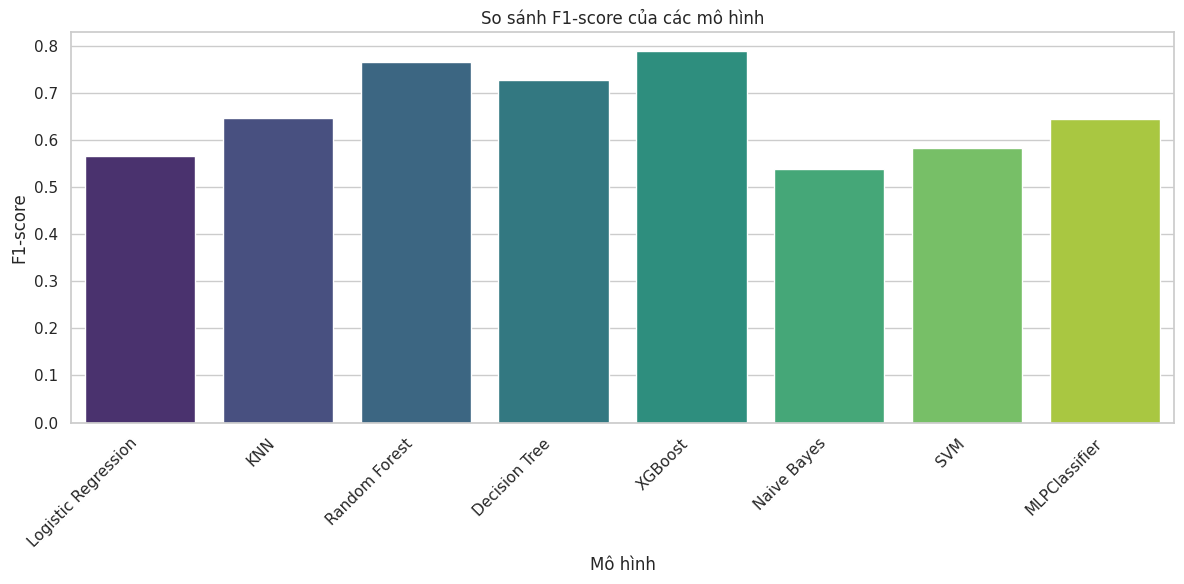

/tmp/ipykernel_8231/1789027266.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='ROC-AUC', data=results_df, palette='magma')


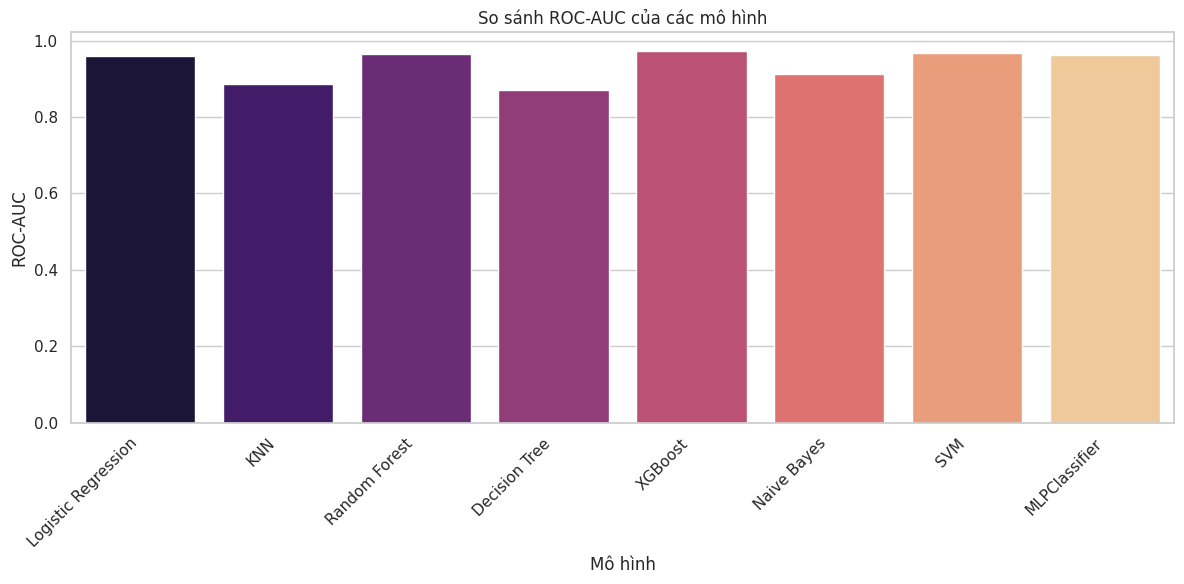

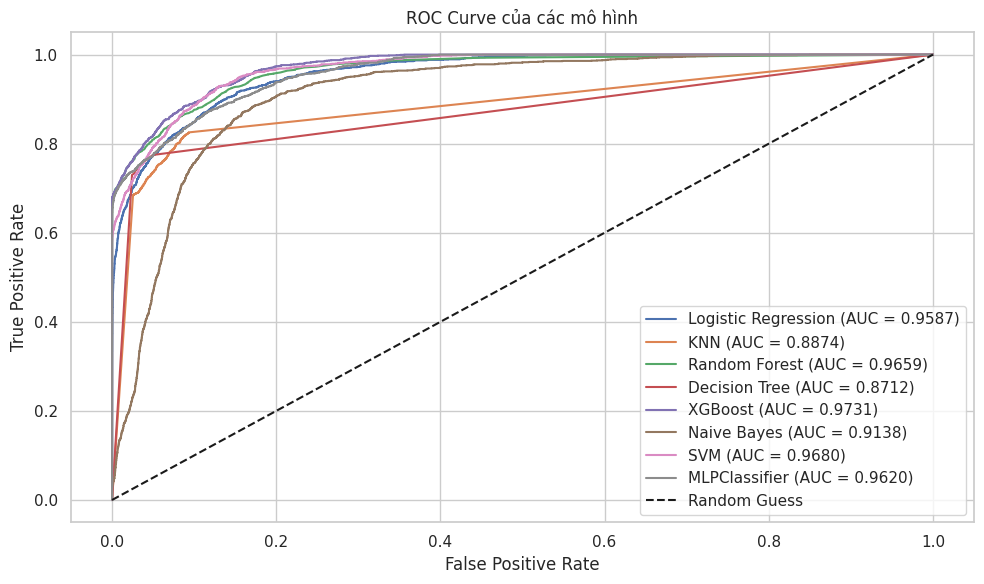

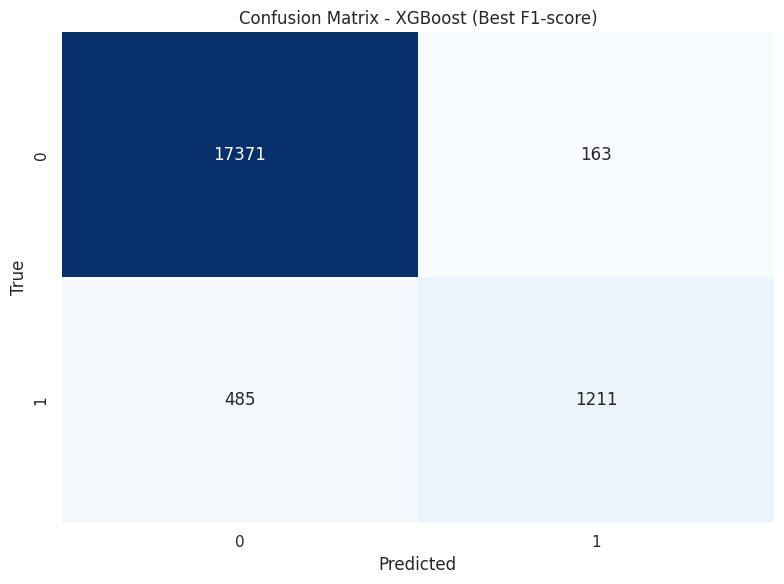


Mô hình tốt nhất dựa trên F1-score: XGBoost (F1-score: 0.7889)


In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Thu thập kết quả từ các mô hình
models = {
    'Logistic Regression': {'y_pred': y_pred_lr, 'y_proba': lr_model.predict_proba(X_test_scaled_IQR)[:, 1], 'time': 10.5},  # Thay time bằng giá trị thực tế
    'KNN': {'y_pred': y_pred_knn, 'y_proba': knn_model.predict_proba(X_test_scaled_IQR)[:, 1], 'time': 15.2},
    'Random Forest': {'y_pred': y_pred_rf, 'y_proba': rf_model.predict_proba(X_test_scaled_IQR)[:, 1], 'time': 25.0},
    'Decision Tree': {'y_pred': y_pred_dt, 'y_proba': dt_model.predict_proba(X_test_scaled_IQR)[:, 1], 'time': 5.0},
    'XGBoost': {'y_pred': y_pred_xgb, 'y_proba': xgb_model.predict_proba(X_test_scaled_IQR)[:, 1], 'time': 30.0},
    'Naive Bayes': {'y_pred': y_pred_nb, 'y_proba': nb_model.predict_proba(X_test_scaled_IQR)[:, 1], 'time': 2.0},
    'SVM': {'y_pred': y_pred_svm, 'y_proba': svm_model.predict_proba(X_test_scaled_IQR)[:, 1], 'time': 40.0},
    'MLPClassifier': {'y_pred': y_pred_mlp, 'y_proba': mlp_model.predict_proba(X_test_scaled_IQR)[:, 1], 'time': 20.0}  # Thay time bằng giá trị thực tế
}

# Thu thập kết quả
results = []
for name, data in models.items():
    accuracy = accuracy_score(y_test_IQR, data['y_pred'])
    precision = precision_score(y_test_IQR, data['y_pred'])
    recall = recall_score(y_test_IQR, data['y_pred'])
    f1 = f1_score(y_test_IQR, data['y_pred'])
    roc_auc = roc_auc_score(y_test_IQR, data['y_proba'])
    training_time = data['time']
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'ROC-AUC': roc_auc,
        'Training Time (s)': training_time
    })

# Tạo DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.round(4)

# In bảng kết quả
print("Bảng so sánh hiệu suất các mô hình:")
print(results_df)

# Lưu bảng
results_df.to_csv('model_comparison_results.csv', index=False)

# 1. Biểu đồ cột: So sánh F1-score
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1-score', data=results_df, palette='viridis')
plt.title('So sánh F1-score của các mô hình')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Mô hình')
plt.ylabel('F1-score')
plt.tight_layout()
plt.savefig('f1_score_comparison.png')
plt.show()

# 2. Biểu đồ cột: So sánh ROC-AUC
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='ROC-AUC', data=results_df, palette='magma')
plt.title('So sánh ROC-AUC của các mô hình')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Mô hình')
plt.ylabel('ROC-AUC')
plt.tight_layout()
plt.savefig('roc_auc_comparison.png')
plt.show()

# # 3. Biểu đồ đường: So sánh thời gian huấn luyện
# plt.figure(figsize=(12, 6))
# sns.lineplot(x='Model', y='Training Time (s)', data=results_df, marker='o', color='red')
# plt.title('Thời gian huấn luyện của các mô hình')
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('Mô hình')
# plt.ylabel('Thời gian (giây)')
# plt.tight_layout()
# plt.savefig('training_time_comparison.png')
# plt.show()

# 4. Biểu đồ ROC Curve
plt.figure(figsize=(10, 6))
for name, data in models.items():
    fpr, tpr, _ = roc_curve(y_test_IQR, data['y_proba'])
    auc_score = roc_auc_score(y_test_IQR, data['y_proba'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve của các mô hình')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.savefig('roc_curves.png')
plt.show()

# 5. Heatmap Confusion Matrix cho mô hình tốt nhất (dựa trên F1-score)
best_model_name = results_df.loc[results_df['F1-score'].idxmax(), 'Model']
best_model_pred = models[best_model_name]['y_pred']
cm = confusion_matrix(y_test_IQR, best_model_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - {best_model_name} (Best F1-score)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig(f'confusion_matrix_{best_model_name.lower().replace(" ", "_")}.png')
plt.show()

# In mô hình tốt nhất
print(f"\nMô hình tốt nhất dựa trên F1-score: {best_model_name} (F1-score: {results_df['F1-score'].max():.4f})")